In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from utils import stationarity_tests

In [2]:
# Load dataset
def load_btc(start="2016-01-01", end=None) -> pd.DataFrame:
    df = yf.download("BTC-USD", start=start, end=end, auto_adjust=True, progress=False)
    if df.empty:
        raise RuntimeError("No data returned.")

    # Handle MultiIndex columns from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.columns = [c.lower() for c in df.columns]
    df = df.reset_index()
    
    # After reset_index, the index becomes a column - find it and rename to 'date'
    if "date" not in df.columns:
        # After lowercasing, it could be "datetime" or just the first column
        if "datetime" in df.columns:
            df = df.rename(columns={"datetime": "date"})
        else:
            # Assume first column is the date/index
            df = df.rename(columns={df.columns[0]: "date"})
    
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")

    df = df[["close", "volume"]].copy()
    df = df.asfreq("D")
    df["close"] = df["close"].interpolate(limit_direction="both")
    df["volume"] = df["volume"].fillna(0.0)
    return df

In [3]:
# Feature engineering lags, rolling stats (shifted), calendar features
def add_fourier_terms(X: pd.DataFrame, period: int, K: int, prefix: str) -> pd.DataFrame:
    t = np.arange(len(X), dtype=float)
    for k in range(1, K + 1):
        X[f"{prefix}_sin_{k}"] = np.sin(2.0 * np.pi * k * t / period)
        X[f"{prefix}_cos_{k}"] = np.cos(2.0 * np.pi * k * t / period)
    return X


def make_supervised_level(
    df: pd.DataFrame,
    horizon: int = 1,
    lags=(1, 2, 3, 7, 14, 21, 28),
    rolling_windows=(7, 14, 28),
    use_fourier=True
) -> tuple[pd.DataFrame, pd.Series]:

    X = df.copy()

    # Calendar features
    X["dayofweek"] = X.index.dayofweek
    X["month"] = X.index.month
    X["weekofyear"] = X.index.isocalendar().week.astype(int)

    # Lags
    for lag in lags:
        X[f"close_lag_{lag}"] = X["close"].shift(lag)
        X[f"volume_lag_{lag}"] = X["volume"].shift(lag)

    # Rolling stats on past values only
    close_shifted = X["close"].shift(1)
    for w in rolling_windows:
        X[f"close_roll_mean_{w}"] = close_shifted.rolling(w).mean()
        X[f"close_roll_std_{w}"] = close_shifted.rolling(w).std()

    # Fourier seasonality (weekly + yearly-ish)
    if use_fourier:
        X = add_fourier_terms(X, period=7, K=3, prefix="wk")
        X = add_fourier_terms(X, period=365, K=3, prefix="yr")

    # Target = future close
    y = df["close"].shift(-horizon)

    # remove raw close at time t from X
    X = X.drop(columns=["close"])

    data = X.join(y.rename("y")).dropna()
    return data.drop(columns=["y"]), data["y"]


def make_supervised_logreturns(
    df: pd.DataFrame,
    horizon: int = 1,
    lags=(1, 2, 3, 7, 14, 21, 28),
    rolling_windows=(7, 14, 28),
    use_fourier=True
) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    tmp = df.copy()
    tmp["log_close"] = np.log(tmp["close"])
    tmp["logret"] = tmp["log_close"].diff(1)

    X = tmp[["volume"]].copy()

    # Calendar
    X["dayofweek"] = X.index.dayofweek
    X["month"] = X.index.month
    X["weekofyear"] = X.index.isocalendar().week.astype(int)

    # Lags of returns & volume
    for lag in lags:
        X[f"logret_lag_{lag}"] = tmp["logret"].shift(lag)
        X[f"volume_lag_{lag}"] = tmp["volume"].shift(lag)

    # Rolling stats on past returns only
    r_shifted = tmp["logret"].shift(1)
    for w in rolling_windows:
        X[f"logret_roll_mean_{w}"] = r_shifted.rolling(w).mean()
        X[f"logret_roll_std_{w}"] = r_shifted.rolling(w).std()

    if use_fourier:
        X = add_fourier_terms(X, period=7, K=3, prefix="wk")
        X = add_fourier_terms(X, period=365, K=3, prefix="yr")

    y = tmp["logret"].shift(-horizon)
    close_t = tmp["close"]

    data = X.join(y.rename("y")).join(close_t.rename("close_t")).dropna()
    return data.drop(columns=["y", "close_t"]), data["y"], data["close_t"]

In [4]:
# Metrics
def rmse(y_true, y_pred) -> float:
    return float(mean_squared_error(y_true, y_pred, squared=False))

def mae(y_true, y_pred) -> float:
    return float(mean_absolute_error(y_true, y_pred))

def print_scores(name: str, y_true, y_pred):
    print(f"{name:28s} MAE={mae(y_true,y_pred):.2f}  RMSE={rmse(y_true,y_pred):.2f}")

In [5]:
# Pipeline 
def make_model_pipeline(X: pd.DataFrame) -> Pipeline:
    # Identify column types
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ],
        remainder="drop"
    )

    model = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        objective="reg:squarederror",
        tree_method="hist"
    )

    return Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

In [6]:
# Backtesting
def backtest_pipeline(pipe: Pipeline, X: pd.DataFrame, y: pd.Series, n_splits=5) -> pd.DataFrame:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rows = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        pred = pipe.predict(X_va)

        rows.append({
            "fold": fold,
            "start_train": X_tr.index.min(),
            "end_train": X_tr.index.max(),
            "start_val": X_va.index.min(),
            "end_val": X_va.index.max(),
            "MAE": mae(y_va, pred),
            "RMSE": rmse(y_va, pred),
        })

    return pd.DataFrame(rows)

In [7]:
# Classical baselines: ARIMA + ETS
def arima_forecast(train_series: pd.Series, test_index: pd.DatetimeIndex) -> pd.Series:
    # lightweight grid search by AIC (small)
    best_aic = np.inf
    best_model = None
    best_order = None

    for p in [0, 1, 2, 3]:
        for d in [0, 1]:
            for q in [0, 1, 2, 3]:
                if (p, d, q) == (0, 0, 0):
                    continue
                try:
                    m = ARIMA(train_series, order=(p, d, q)).fit()
                    if m.aic < best_aic:
                        best_aic, best_model, best_order = m.aic, m, (p, d, q)
                except Exception:
                    pass

    if best_model is None:
        raise RuntimeError("ARIMA grid search failed to fit any model.")

    fc = best_model.forecast(steps=len(test_index))
    fc.index = test_index
    print(f"ARIMA best order={best_order}, AIC={best_aic:.1f}")
    return fc


def ets_forecast(train_series: pd.Series, test_index: pd.DatetimeIndex) -> pd.Series:
    # Try weekly seasonality; fallback to trend-only
    try:
        m = ExponentialSmoothing(
            train_series,
            trend="add",
            seasonal="add",
            seasonal_periods=7,
            initialization_method="estimated"
        ).fit(optimized=True)
    except Exception:
        m = ExponentialSmoothing(
            train_series,
            trend="add",
            seasonal=None,
            initialization_method="estimated"
        ).fit(optimized=True)

    fc = m.forecast(len(test_index))
    fc.index = test_index
    return fc

                   close       volume
date                                 
2025-12-24  87611.960938  25550297986
2025-12-25  87234.742188  19953216347
2025-12-26  87301.429688  42455674908
2025-12-27  87802.156250  13741199310
2025-12-28  87506.734375  14852080640
Date range: 2016-01-01 -> 2025-12-28


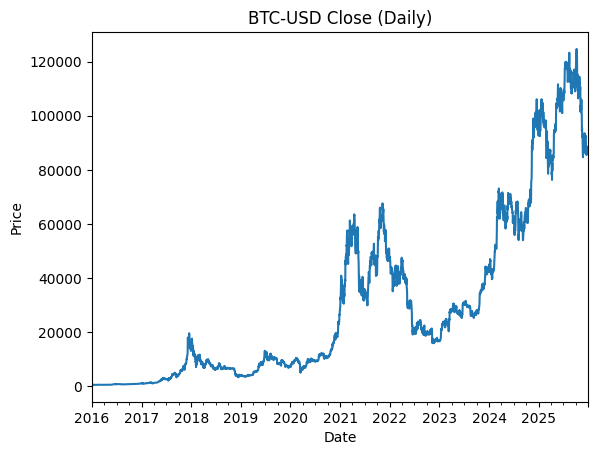

In [8]:
# load data and plot
df = load_btc(start="2016-01-01")
print(df.tail())
print("Date range:", df.index.min().date(), "->", df.index.max().date())

plt.figure()
df["close"].plot()
plt.title("BTC-USD Close (Daily)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

Backtest (XGB on level):


,fold,start_train,end_train,start_val,end_val,MAE,RMSE
0,1,2016-01-29,2017-05-28,2017-05-29,2018-09-22,5294.015031,6412.920745
1,2,2016-01-29,2018-09-22,2018-09-23,2020-01-17,758.905098,1254.712533
2,3,2016-01-29,2020-01-17,2020-01-18,2021-05-13,11312.376869,20187.095120
3,4,2016-01-29,2021-05-13,2021-05-14,2022-09-07,7157.803354,9195.912062
4,5,2016-01-29,2022-09-07,2022-09-08,2024-01-02,1982.539269,2463.412293


Mean backtest RMSE: 7902.810550635176
XGBoost (level, holdout)     MAE=27148.93  RMSE=34198.55


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA best order=(3, 1, 3), AIC=47239.6
ARIMA (level, holdout)       MAE=39115.89  RMSE=44772.23
ETS (level, holdout)         MAE=37667.28  RMSE=43139.69


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


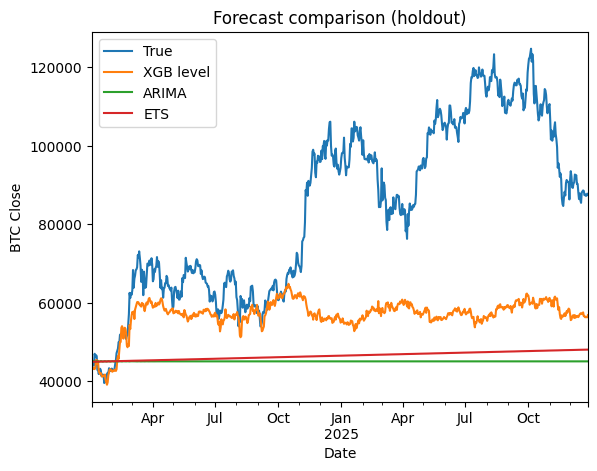

In [9]:
# Level forecasting with ML + backtest + final holdout
X_level, y_level = make_supervised_level(df, horizon=1)

# Holdout split (no shuffle): last 20% as test
split_point = int(len(X_level) * 0.8)
X_tr, X_te = X_level.iloc[:split_point], X_level.iloc[split_point:]
y_tr, y_te = y_level.iloc[:split_point], y_level.iloc[split_point:]

pipe_level = make_model_pipeline(X_tr)

print("Backtest (XGB on level):")
bt = backtest_pipeline(pipe_level, X_tr, y_tr, n_splits=5)
display(bt)
print("Mean backtest RMSE:", bt["RMSE"].mean())

pipe_level.fit(X_tr, y_tr)
pred_level = pipe_level.predict(X_te)
print_scores("XGBoost (level, holdout)", y_te, pred_level)

# Classical baselines
train_series = df.loc[X_tr.index.min():X_tr.index.max(), "close"]
test_index = X_te.index

arima_pred = arima_forecast(train_series, test_index)
ets_pred = ets_forecast(train_series, test_index)

print_scores("ARIMA (level, holdout)", y_te, arima_pred.values)
print_scores("ETS (level, holdout)", y_te, ets_pred.values)

plt.figure()
y_te.plot(label="True")
pd.Series(pred_level, index=test_index).plot(label="XGB level")
arima_pred.plot(label="ARIMA")
ets_pred.plot(label="ETS")
plt.title("Forecast comparison (holdout)")
plt.xlabel("Date"); plt.ylabel("BTC Close")
plt.legend()
plt.show()

The holdout forecast shows that none of the level-based models are able to track the strong upward and downward movements of Bitcoin prices.  
The XGBoost level model performs better than ARIMA and ETS, but it still strongly underestimates large price changes and fails to follow regime shifts.

Both ARIMA and ETS produce almost flat forecasts, indicating that these models are not suitable for capturing the high volatility and nonlinear dynamics of cryptocurrency prices.

Stationarity tests for close level:
Stationarity Test Results:
	- ADF: Non-Stationary (p-value: 0.8170)
	- PP: Non-Stationary (p-value: 0.8760)
	- KPSS: Non-Stationary (p-value: 0.0001)
	- ZA: Non-Stationary (p-value: 0.3923)

Stationarity tests for log returns:
Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.2569)
	- ZA: Stationary (p-value: 0.0000)
Backtest (XGB on log-returns):


,fold,start_train,end_train,start_val,end_val,MAE,RMSE
0,1,2016-01-30,2017-05-29,2017-05-30,2018-09-23,0.039001,0.053554
1,2,2016-01-30,2018-09-23,2018-09-24,2020-01-18,0.041160,0.052658
2,3,2016-01-30,2020-01-18,2020-01-19,2021-05-14,0.028383,0.043807
3,4,2016-01-30,2021-05-14,2021-05-15,2022-09-08,0.029847,0.039225
4,5,2016-01-30,2022-09-08,2022-09-09,2024-01-03,0.018046,0.025944


Mean backtest RMSE (returns): 0.04303762970016489
XGBoost (logret->price)      MAE=1662.05  RMSE=2236.37


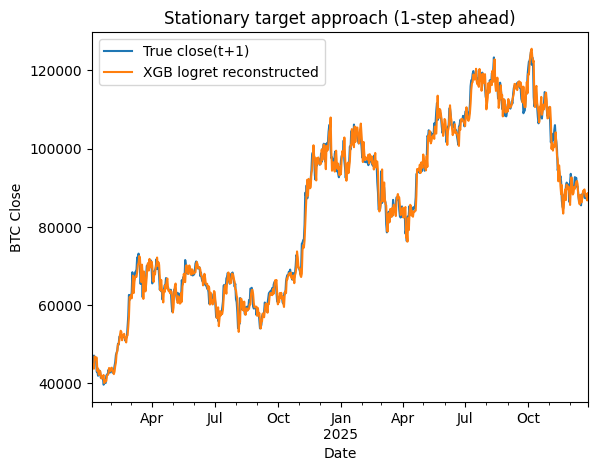

In [10]:
# Stationarity: log returns, retrain ML, reconstruct
df["log_close"] = np.log(df["close"])
df["logret"] = df["log_close"].diff(1)

print("Stationarity tests for close level:")
stationarity_tests(df["close"].values)
print("\nStationarity tests for log returns:")
stationarity_tests(df["logret"].dropna().values)

X_ret, y_ret, close_t = make_supervised_logreturns(df, horizon=1)

split_point2 = int(len(X_ret) * 0.8)
Xr_tr, Xr_te = X_ret.iloc[:split_point2], X_ret.iloc[split_point2:]
yr_tr, yr_te = y_ret.iloc[:split_point2], y_ret.iloc[split_point2:]
close_t_te = close_t.iloc[split_point2:]

pipe_ret = make_model_pipeline(Xr_tr)

print("Backtest (XGB on log-returns):")
bt2 = backtest_pipeline(pipe_ret, Xr_tr, yr_tr, n_splits=5)
display(bt2)
print("Mean backtest RMSE (returns):", bt2["RMSE"].mean())

pipe_ret.fit(Xr_tr, yr_tr)
pred_ret = pipe_ret.predict(Xr_te)

# Reconstruct 1-step ahead price:
# close_{t+1} = close_t * exp(pred_logret_{t+1})
pred_price = close_t_te.values * np.exp(pred_ret)

# True next-day close aligned with Xr_te index
true_next_close = df["close"].shift(-1).loc[Xr_te.index]

print_scores("XGBoost (logret->price)", true_next_close, pred_price)

plt.figure()
true_next_close.plot(label="True close(t+1)")
pd.Series(pred_price, index=Xr_te.index).plot(label="XGB logret reconstructed")
plt.title("Stationary target approach (1-step ahead)")
plt.xlabel("Date"); plt.ylabel("BTC Close")
plt.legend()
plt.show()


Stationarity tests show that Bitcoin prices in levels are non-stationary, while log-returns are stationary according to all tests. This makes log-returns a more appropriate target for modeling.

Using log-returns with XGBoost and reconstructing prices leads to a strong improvement in forecast accuracy. The one-step-ahead forecasts closely follow the true price movements, including rapid increases and decreases.

Rolling backtest results show stable and low errors across all folds, indicating robust performance over time. Compared to level-based models, the stationary target approach produces much lower MAE and RMSE on the holdout set and handles volatility more effectively.
